In [1]:
import sys, os
sys.path.insert(0, "/home/storage/hans/jax_reco_new/")
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['XLA_FLAGS'] = "--xla_disable_hlo_passes=constant_folding"

from tensorflow_probability.substrates import jax as tfp

import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
import optimistix as optx

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import optax
import optax.tree_utils as otu

In [2]:
# TriplePandelSPE/JAX stuff
from lib.simdata_i3 import I3SimHandler
from lib.geo import center_track_pos_and_time_based_on_data
#from lib.smaller_network_eqx import get_network_eval_v_fn
from lib.smallest_network_eqx import get_network_eval_v_fn
from dom_track_eval import get_eval_network_doms_and_track
#from likelihood_mpe_w_noise import get_neg_c_triple_gamma_llh
#from likelihood_spe_w_noise_logsumexp import get_neg_c_triple_gamma_llh
#from likelihood_conv_mpe_w_noise_logsumexp import get_neg_c_triple_gamma_llh
#from likelihood_conv_mpe_w_noise import get_neg_c_triple_gamma_llh
#from likelihood_conv_spe_w_noise import get_neg_c_triple_gamma_llh
from likelihood_conv_spe_w_noise_logsumexp import get_neg_c_triple_gamma_llh
from palettable.cubehelix import Cubehelix
cx =Cubehelix.make(start=0.3, rotation=-0.5, n=16, reverse=True, gamma=1.0,
                           max_light=1.0,max_sat=0.5, min_sat=1.4).get_mpl_colormap()

import time

In [3]:
# Number of scan points on 1D
n_eval = 50 # making it a 20x20 grid

# Scan range (truth +/- dzen, +/- dazi)
dzen = 0.2 # rad
dazi = 0.2 # rad

#dzen = 0.05
#dazi = 0.05

# Event Index.
event_index = 4

# Get network and eval logic.
dtype = jnp.float64
#eval_network_v = get_network_eval_v_fn(bpath='/home/storage/hans/jax_reco_new/data/smaller_network_eqx/tpn_smallest_default_tree_start_epoch_192', dtype=jnp.float64)
eval_network_v = get_network_eval_v_fn(bpath='/home/storage/hans/photondata/large_table_training/all_time_bins/no_penalties/cache/tpn_smallest_default_only_4_layers_48_no_penalties_large_dataset_tree_start_epoch_50', dtype=jnp.float64)
eval_network_doms_and_track = get_eval_network_doms_and_track(eval_network_v, dtype=jnp.float64)

In [4]:
# Get an IceCube event.
bp = '/home/storage2/hans/i3files/21217'

sim_handler = I3SimHandler(os.path.join(bp, 'meta_ds_21217_from_35000_to_53530.ftr'),
                              os.path.join(bp, 'pulses_ds_21217_from_35000_to_53530.ftr'),
                              '/home/storage/hans/jax_reco_new/data/icecube/detector_geometry.csv')

meta, pulses = sim_handler.get_event_data(event_index)
print(f"muon energy: {meta['muon_energy_at_detector']/1.e3:.1f} TeV")

# Get dom locations, first hit times, and total charges (for each dom).
event_data = sim_handler.get_per_dom_summary_from_sim_data(meta, pulses)

print("n_doms", len(event_data))

muon energy: 6.2 TeV
n_doms 45


In [5]:
# Make MCTruth seed.
track_pos = jnp.array([meta['muon_pos_x'], meta['muon_pos_y'], meta['muon_pos_z']])
track_time = meta['muon_time']
track_zenith = meta['muon_zenith']
track_azimuth = meta['muon_azimuth']
track_src = jnp.array([track_zenith, track_azimuth])

print("original seed vertex:", track_pos)
centered_track_pos, centered_track_time = center_track_pos_and_time_based_on_data(event_data, track_pos, track_time, track_src)
print("shifted seed vertex:", centered_track_pos)

original seed vertex: [  -65.71173861  1800.82339061 -1057.15159503]
shifted seed vertex: [ 407.88112043  162.47186024 -234.15666758]


In [6]:
# Clip charge and combine into single data tensor for fitting.
fitting_event_data = jnp.array(event_data[['x', 'y', 'z', 'time', 'charge']].to_numpy())
print(fitting_event_data.shape)

# Setup likelihood
neg_llh = get_neg_c_triple_gamma_llh(eval_network_doms_and_track)
print(neg_llh(track_src, centered_track_pos, centered_track_time, fitting_event_data))
negllh_time_v = jax.vmap(neg_llh, (None, None, 0, None), 0)

(45, 5)
582.5347228823791


In [7]:
scale = 30.0
scale_rad = 30.0

@jax.jit
def neg_llh_5D(x, args):
        # project back if outside of [0, pi] x [0, 2*pi]
        zenith = x[0] / scale_rad
        azimuth = x[1] / scale_rad
        zenith = jnp.fmod(zenith, 2.0*jnp.pi)
        zenith = jnp.where(zenith < 0, zenith+2.0*jnp.pi, zenith)
        cond = zenith > jnp.pi
        zenith = jnp.where(cond, -1.0*zenith+2.0*jnp.pi, zenith)
        azimuth = jnp.where(cond, azimuth-jnp.pi, azimuth)

        azimuth = jnp.fmod(azimuth, 2.0*jnp.pi)
        azimuth = jnp.where(azimuth < 0, azimuth+2.0*jnp.pi, azimuth)

        projected_dir = jnp.array([zenith, azimuth])
        return neg_llh(projected_dir, x[2:]*scale, centered_track_time, fitting_event_data)

In [8]:
def optax_fun(x):
    return neg_llh_5D(x, None)

@jax.jit
def run_opt(init_params, max_iter, tol):
  fun = optax_fun
  value_and_grad_fun = optax.value_and_grad_from_state(fun)

  def step(carry):
    params, state = carry
    value, grad = value_and_grad_fun(params, state=state)
    updates, state = opt.update(
        grad, state, params, value=value, grad=grad, value_fn=fun
    )
    params = optax.apply_updates(params, updates)
    return params, state

  def continuing_criterion(carry):
    _, state = carry
    iter_num = otu.tree_get(state, 'count')
    grad = otu.tree_get(state, 'grad')
    err = otu.tree_l2_norm(grad)
    return (iter_num == 0) | ((iter_num < max_iter) & (err >= tol))

  init_carry = (init_params, opt.init(init_params))
  final_params, final_state = jax.lax.while_loop(
      continuing_criterion, step, init_carry
  )
  return final_params, final_state

opt = optax.lbfgs()
solver = optx.BFGS(rtol=1e-10, atol=1e-10, use_inverse=True)

x0 = jnp.concatenate([track_src*scale_rad, centered_track_pos/scale])

best_x_optx = optx.minimise(neg_llh_5D, solver, x0, throw=False).value
print(best_x_optx)

print(neg_llh_5D(x0, None))
best_x, _ = run_opt(x0, max_iter=jnp.array(100), tol=jnp.array(1e-5))
print(best_x)

[60.83999487 55.21720983 13.48492564  5.3453027  -7.84005184]
582.5347228823791
[60.83999493 55.21720977 13.48492562  5.34530271 -7.84005183]


In [9]:
@jax.jit
def fun(x0):
    return optx.minimise(neg_llh_5D, solver, x0, throw=False).value

In [10]:
fun(x0)

Array([60.83999487, 55.21720983, 13.48492564,  5.3453027 , -7.84005184],      dtype=float64)

In [11]:
%timeit fun(x0)

14.6 ms ± 14.7 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
%timeit run_opt(x0, max_iter=jnp.array(100), tol=jnp.array(1e-5))

15.3 ms ± 34.5 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
def neg_llh_3D(x, args):
    track_dir = args[:2]
    track_time = args[2]
    return neg_llh(track_dir, x*scale, track_time, fitting_event_data)

@jax.jit
def run_opt(init_params, args, max_iter, tol):
  fun = neg_llh_3D
  value_and_grad_fun = optax.value_and_grad_from_state(fun)

  def step(carry):
    params, state = carry
    value, grad = value_and_grad_fun(params, args, state=state)
    updates, state = opt.update(
        grad, state, params, value=value, grad=grad, value_fn=fun, args=args
    )
    params = optax.apply_updates(params, updates)
    return params, state

  def continuing_criterion(carry):
    _, state = carry
    iter_num = otu.tree_get(state, 'count')
    grad = otu.tree_get(state, 'grad')
    err = otu.tree_l2_norm(grad)
    return (iter_num == 0) | ((iter_num < max_iter) & (err >= tol))

  init_carry = (init_params, opt.init(init_params))
  final_params, final_state = jax.lax.while_loop(
      continuing_criterion, step, init_carry
  )
  return final_params, final_state

opt = optax.lbfgs()

x0 = jnp.concatenate([centered_track_pos/scale])
args = jnp.concatenate([track_src, jnp.expand_dims(centered_track_time, axis=0)])


print(neg_llh_3D(x0, args))
best_x, _ = run_opt(x0, args, max_iter=jnp.array(100), tol=jnp.array(1e-3))
print(best_x)

582.5347228823791
[13.55916933  5.29568496 -7.87409105]


In [14]:
track_src

Array([2.02040598, 1.85219263], dtype=float64)

In [15]:
def run_3D(track_dir, track_time):
    args = jnp.concatenate([track_dir, jnp.expand_dims(track_time, axis=0)])
    values, _ = run_opt(x0, args, max_iter=jnp.array(100), tol=jnp.array(1e-3))
    return neg_llh_3D(values, args), values * scale

In [16]:
run_3D(track_src, centered_track_time)

(Array(578.41021303, dtype=float64),
 Array([ 406.77507994,  158.87054894, -236.22273154], dtype=float64))

In [17]:
centered_track_pos

Array([ 407.88112043,  162.47186024, -234.15666758], dtype=float64)

In [18]:
run_3D_v = jax.jit(jax.vmap(run_3D, (0, 0), (0, 0)))

In [19]:
zenith = jnp.linspace(track_src[0]-dzen, track_src[0]+dazi, n_eval)
azimuth = jnp.linspace(track_src[1]-dzen, track_src[1]+dazi, n_eval)
X, Y = jnp.meshgrid(zenith, azimuth)
init_dirs = jnp.column_stack([X.flatten(), Y.flatten()])

dt = 500.
tv = jnp.linspace(centered_track_time - dt, centered_track_time + 100, 200)

@jax.jit
def get_track_time(track_dir):
    llh = negllh_time_v(track_dir, centered_track_pos, tv, fitting_event_data)
    ix = jnp.argmin(llh, axis=0)
    return ix

get_track_time_v = jax.jit(jax.vmap(get_track_time, 0, 0))

tic = time.time()
n_splits = 20
_init_dirs = init_dirs.reshape((n_splits, init_dirs.shape[0]//n_splits , init_dirs.shape[1]))
indices = []
for i, x in enumerate(_init_dirs):
    print("done w timebatch: ", i)
    indices.append(get_track_time_v(x))

indices = jnp.concatenate(indices)
init_times = jnp.take_along_axis(tv, indices, axis=0)
toc = time.time()
print(f"extraction of init times for grid took {toc-tic:.1f}s.")

done w timebatch:  0
done w timebatch:  1
done w timebatch:  2
done w timebatch:  3
done w timebatch:  4
done w timebatch:  5
done w timebatch:  6
done w timebatch:  7
done w timebatch:  8
done w timebatch:  9
done w timebatch:  10
done w timebatch:  11
done w timebatch:  12
done w timebatch:  13
done w timebatch:  14
done w timebatch:  15
done w timebatch:  16
done w timebatch:  17
done w timebatch:  18
done w timebatch:  19
extraction of init times for grid took 2.8s.


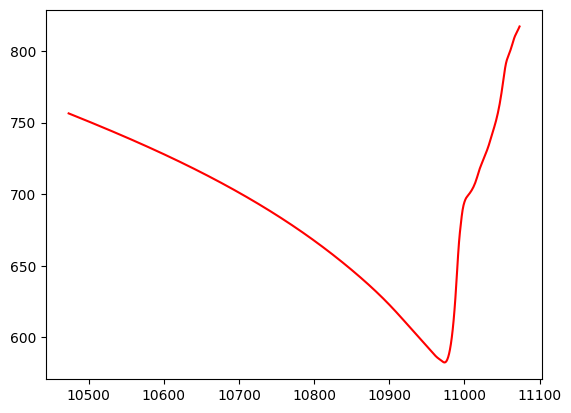

In [54]:
tv2 = jnp.linspace(centered_track_time - dt, centered_track_time + 100, 500)

llh = negllh_time_v(track_src, centered_track_pos, tv2, fitting_event_data)
plt.plot(tv2, llh, "r-")
#plt.scatter(tv ,llh, marker='o', s=5, color='k')

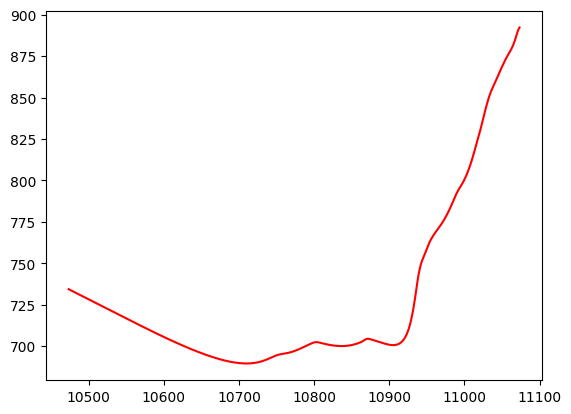

In [55]:
llh = negllh_time_v(jnp.array([jnp.deg2rad(125), jnp.deg2rad(115)]), centered_track_pos, tv2, fitting_event_data)
plt.plot(tv2, llh, "r-")
#plt.scatter(tv ,llh, marker='o', s=5, color='k')

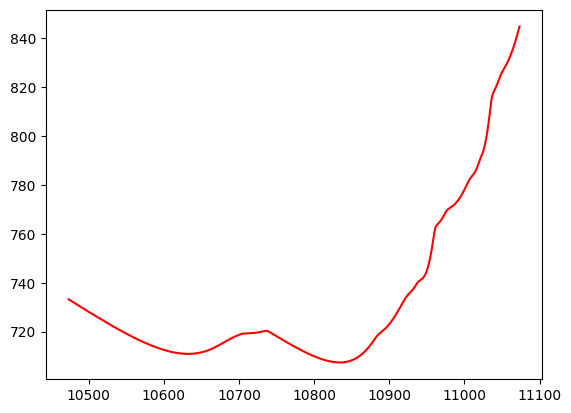

In [56]:
llh = negllh_time_v(jnp.array([jnp.deg2rad(105), jnp.deg2rad(115)]), centered_track_pos, tv2, fitting_event_data)
plt.plot(tv2, llh, "r-")
#plt.scatter(tv ,llh, marker='o', s=5, color='k')

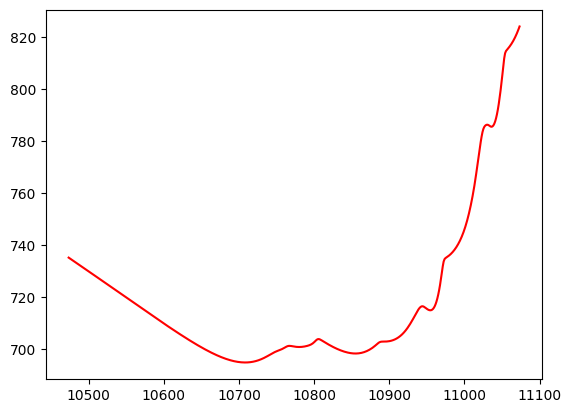

In [57]:
llh = negllh_time_v(jnp.array([jnp.deg2rad(105), jnp.deg2rad(110)]), centered_track_pos, tv2, fitting_event_data)
plt.plot(tv2, llh, "r-")
#plt.scatter(tv ,llh, marker='o', s=5, color='k')

In [22]:
print(jnp.min(centered_track_time - init_times))
print(jnp.max(centered_track_time - init_times))

-0.5025125628126261
349.24623115577924


In [23]:
tic = time.time()
logls, sol_pos = run_3D_v(init_dirs, init_times)
toc = time.time()
print(f"jit + reco of grid took {toc-tic:.1f}s.")

jit + reco of grid took 80.7s.


In [24]:
print(init_dirs.shape, init_times.shape)

(2500, 2) (2500,)


In [25]:
print(logls)
print(sol_pos)

[649.88606592 648.5645868  647.26475295 ... 676.28947199 677.71804192
 679.08194119]
[[ 412.70107193  171.91153208 -280.0428905 ]
 [ 412.06094131  170.50485503 -279.12729777]
 [ 411.34746912  169.10832672 -278.06349655]
 ...
 [ 430.17062187  206.86945326 -243.21105819]
 [ 431.98497107  207.37436729 -243.51111024]
 [ 434.41193407  207.71652172 -243.66338125]]


In [26]:
print(jnp.min(sol_pos[:, 0]))

389.122518407769


In [27]:
print(jnp.max(sol_pos[:, 0]))

446.7461675924533


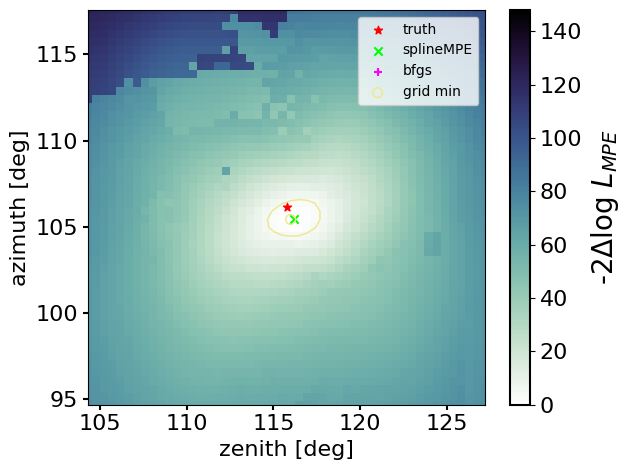

In [28]:
logls = logls.reshape(X.shape)

fig, ax = plt.subplots()
min_logl = np.amin(logls)
delta_logl = logls - np.amin(logls)
pc = ax.pcolormesh(np.rad2deg(X), np.rad2deg(Y), delta_logl, vmin=0, vmax=np.min([500, 1.2*np.amax(delta_logl)]), shading='auto', cmap=cx)
cbar = fig.colorbar(pc)
cbar.ax.tick_params(labelsize=16)
cbar.ax.get_yaxis().labelpad = 5
cbar.set_label("-2$\\Delta$log $L_{MPE}$", fontsize=20)
cbar.outline.set_linewidth(1.5)

ax.set_xlabel("zenith [deg]", fontsize=16)
ax.set_ylabel("azimuth [deg]", fontsize=16)
ax.set_xlim(np.rad2deg([track_src[0]-dzen, track_src[0]+dzen]))
ax.set_ylim(np.rad2deg([track_src[1]-dazi, track_src[1]+dazi]))
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)

ax.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="*", color='red', label="truth", zorder=200)

smpe_zenith = meta['spline_mpe_zenith']
smpe_azimuth = meta['spline_mpe_azimuth']
ax.scatter(np.rad2deg([smpe_zenith]), np.rad2deg([smpe_azimuth]), marker="x", color='lime', label='splineMPE')

zenith = best_x[0] / scale_rad
azimuth = best_x[1] / scale_rad
ax.scatter(np.rad2deg(zenith), np.rad2deg(azimuth), marker='+', color='magenta', label='bfgs')

contours = [4.61]
ix1, ix2 = np.where(delta_logl==0)
ax.scatter(np.rad2deg([X[ix1, ix2]]), np.rad2deg([Y[ix1, ix2]]), s=50, marker='o', facecolors='none', edgecolors='khaki', zorder=100., label='grid min')
ct = plt.contour(np.rad2deg(X), np.rad2deg(Y), delta_logl, levels=contours, linestyles=['solid'], colors=['khaki'], linewidths=1.0)

plt.legend()
plt.tight_layout()
plt.show()

In [29]:
run_3D(track_src, centered_track_time)

(Array(578.41021303, dtype=float64),
 Array([ 406.77507994,  158.87054894, -236.22273154], dtype=float64))

In [30]:
centered_track_pos

Array([ 407.88112043,  162.47186024, -234.15666758], dtype=float64)

In [31]:
def run_3D_optx(track_dir, track_time):
    args = jnp.concatenate([track_dir, jnp.expand_dims(track_time, axis=0)])
    values = optx.minimise(neg_llh_3D, solver, x0, args=args, throw=False).value
    return neg_llh_3D(values, args), values * scale

run_3D_optx_v = jax.jit(jax.vmap(run_3D_optx, 0, (0, 0)))

In [32]:
tic = time.time()
logls_optx, sol_pos_optx = run_3D_optx_v(init_dirs, init_times)
toc = time.time()
print(f"jit + reco of grid took {toc-tic:.1f}s.")


jit + reco of grid took 8.3s.


In [33]:
dx = jnp.linalg.norm(sol_pos - sol_pos_optx, axis=1)
ix = dx > 10

In [34]:
print(jnp.sort(logls.flatten()[ix]-logls_optx.flatten()[ix]))

[-2.81958022e+01 -1.29795669e+01 -9.71050982e+00 -9.19162162e+00
 -8.58233700e+00 -8.14716726e+00 -7.87925479e+00 -4.21768904e+00
 -4.01681577e+00 -3.98165378e+00 -3.91068007e+00 -3.87491421e+00
 -3.80944439e+00 -3.41550894e+00 -2.94607574e+00 -2.94145037e+00
 -2.59834418e+00 -2.51652584e+00 -2.04478002e+00 -1.81123786e+00
 -1.67668988e+00 -1.60838354e+00 -1.56500375e+00 -1.55675000e+00
 -1.50499808e+00 -1.20123445e+00 -1.17521165e+00 -1.03505375e+00
 -9.95510084e-01 -9.56386325e-01 -9.19536177e-01 -9.11806314e-01
 -7.66768197e-01 -7.12552867e-01 -6.94592921e-01 -6.79395256e-01
 -6.57952920e-01 -6.30034878e-01 -5.70099690e-01 -5.59484039e-01
 -4.99550254e-01 -4.83941530e-01 -4.70878740e-01 -3.53366053e-01
 -3.43148175e-01 -2.58160231e-01 -2.08554843e-01 -1.93823737e-01
 -1.80445207e-01 -1.54007549e-01 -1.14320856e-01 -1.07024563e-01
 -3.71761595e-02  1.48473212e-02  2.27386675e-02  3.82284381e-02
  6.23207899e-02  7.75165907e-02  8.31445561e-02  1.93004391e-01
  2.05307709e-01  2.13997

In [35]:
len(init_dirs)

2500

In [36]:
init_dirs[ix]

Array([[1.97550802, 1.65219263],
       [2.04897741, 1.65219263],
       [2.15509986, 1.65219263],
       [2.16326313, 1.65219263],
       [2.17142639, 1.65219263],
       [2.17958966, 1.65219263],
       [2.18775292, 1.65219263],
       [2.19591619, 1.65219263],
       [1.97550802, 1.66035589],
       [2.04897741, 1.66035589],
       [2.05714068, 1.66035589],
       [2.15509986, 1.66035589],
       [2.16326313, 1.66035589],
       [2.17142639, 1.66035589],
       [2.17958966, 1.66035589],
       [2.18775292, 1.66035589],
       [2.19591619, 1.66035589],
       [1.97550802, 1.66851916],
       [2.04897741, 1.66851916],
       [2.16326313, 1.66851916],
       [2.17142639, 1.66851916],
       [2.17958966, 1.66851916],
       [2.18775292, 1.66851916],
       [2.19591619, 1.66851916],
       [1.97550802, 1.67668243],
       [2.00816108, 1.67668243],
       [2.17142639, 1.67668243],
       [2.17958966, 1.67668243],
       [2.18775292, 1.67668243],
       [2.19591619, 1.67668243],
       [2.

In [37]:
print(logls_optx.flatten()[ix])

[636.73942181 637.60606822 641.46283502 642.29507328 643.91360889
 644.41435906 645.16239798 646.1761001  635.36717882 636.61655794
 637.1826888  640.70355901 641.55907232 642.6169498  643.71034296
 644.51192283 645.57830196 633.81061778 635.37815438 640.87038484
 641.95505143 643.00284306 643.86784757 644.99434508 632.05388923
 633.48129699 641.37108235 642.31021486 643.24607698 644.43727434
 640.86941929 641.6518183  642.66216821 643.91902617 641.04449089
 642.12882638 643.44899901 640.49840881 641.65334453 643.03235959
 641.23580127 642.66805659 640.86727132 642.34682652 640.52920233
 642.05460386 640.20621588 641.78906278 639.90723132 641.56449699
 641.39628788 643.2459299  641.29226856 643.22450238 641.25090362
 647.40703009 645.53485163 613.01597445 627.09590332 639.52630935
 648.16225481 645.57505206 628.83392881 638.25953672 641.06552898
 645.42452919 645.29460781 642.51090938 639.6665569  636.79680958
 611.63619379 621.44063046 624.67560373 627.97993866 648.19981653
 636.23518

In [38]:
dx = jnp.linalg.norm(sol_pos - centered_track_pos, axis=1)

In [39]:
dx

Array([47.0944242 , 45.87327639, 44.54063191, ..., 50.4970309 ,
       51.81444155, 53.30423125], dtype=float64)

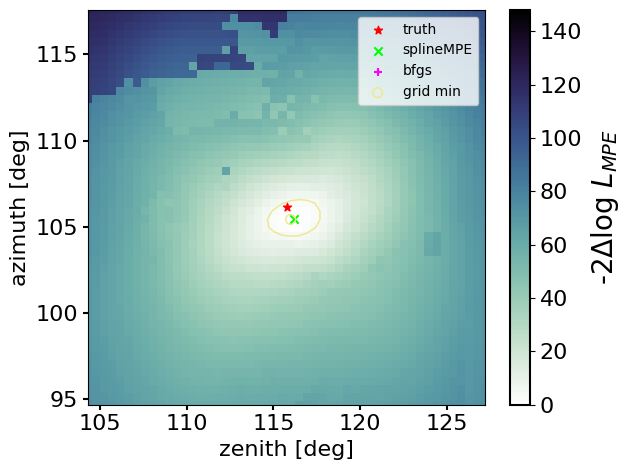

In [48]:
logls = logls.reshape(X.shape)

fig, ax = plt.subplots()
min_logl = np.amin(logls)
delta_logl = logls - np.amin(logls)
pc = ax.pcolormesh(np.rad2deg(X), np.rad2deg(Y), delta_logl, vmin=0, vmax=np.min([500, 1.2*np.amax(delta_logl)]), shading='auto', cmap=cx)
cbar = fig.colorbar(pc)
cbar.ax.tick_params(labelsize=16)
cbar.ax.get_yaxis().labelpad = 5
cbar.set_label("-2$\\Delta$log $L_{MPE}$", fontsize=20)
cbar.outline.set_linewidth(1.5)

ax.set_xlabel("zenith [deg]", fontsize=16)
ax.set_ylabel("azimuth [deg]", fontsize=16)
ax.set_xlim(np.rad2deg([track_src[0]-dzen, track_src[0]+dzen]))
ax.set_ylim(np.rad2deg([track_src[1]-dazi, track_src[1]+dazi]))
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)

ax.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="*", color='red', label="truth", zorder=200)

smpe_zenith = meta['spline_mpe_zenith']
smpe_azimuth = meta['spline_mpe_azimuth']
ax.scatter(np.rad2deg([smpe_zenith]), np.rad2deg([smpe_azimuth]), marker="x", color='lime', label='splineMPE')

zenith = best_x[0] / scale_rad
azimuth = best_x[1] / scale_rad
ax.scatter(np.rad2deg(zenith), np.rad2deg(azimuth), marker='+', color='magenta', label='bfgs')

contours = [4.61]
ix1, ix2 = np.where(delta_logl==0)
ax.scatter(np.rad2deg([X[ix1, ix2]]), np.rad2deg([Y[ix1, ix2]]), s=50, marker='o', facecolors='none', edgecolors='khaki', zorder=100., label='grid min')
ct = plt.contour(np.rad2deg(X), np.rad2deg(Y), delta_logl, levels=contours, linestyles=['solid'], colors=['khaki'], linewidths=1.0)
#ax.scatter(np.rad2deg(init_dirs[:,0][ix]), np.rad2deg(init_dirs[:,1][ix]), marker='x', color='red')
plt.legend()
plt.tight_layout()
plt.show()

In [41]:
np.rad2deg(init_dirs[:,0][ix])

array([113.18827212, 117.39775796, 123.4781264 , 123.94584705,
       124.4135677 , 124.88128834, 125.34900899, 125.81672964,
       113.18827212, 117.39775796, 117.86547861, 123.4781264 ,
       123.94584705, 124.4135677 , 124.88128834, 125.34900899,
       125.81672964, 113.18827212, 117.39775796, 123.94584705,
       124.4135677 , 124.88128834, 125.34900899, 125.81672964,
       113.18827212, 115.05915471, 124.4135677 , 124.88128834,
       125.34900899, 125.81672964, 124.4135677 , 124.88128834,
       125.34900899, 125.81672964, 124.88128834, 125.34900899,
       125.81672964, 124.88128834, 125.34900899, 125.81672964,
       125.34900899, 125.81672964, 125.34900899, 125.81672964,
       125.34900899, 125.81672964, 125.34900899, 125.81672964,
       125.34900899, 125.81672964, 125.81672964, 126.28445029,
       125.81672964, 126.28445029, 125.81672964, 127.21989159,
       126.75217094, 120.20408185, 123.01040575, 123.94584705,
       104.76930043, 105.23702108, 123.4781264 , 123.94

In [42]:
print(x0*scale)

[ 407.88112043  162.47186024 -234.15666758]


In [43]:
jnp.linalg.norm(sol_pos[ix]-(x0*scale), axis=1)

Array([32.4746088 ,  9.33674745, 25.66111602, 27.25745132, 28.90569671,
       30.65612096, 32.59938993, 34.95491782, 32.0994379 ,  7.63915498,
       11.82962093, 24.768139  , 26.41989117, 28.11939124, 29.92186634,
       31.92149012, 34.33682806, 31.52931093,  7.28221788, 25.60469719,
       26.93148955, 28.78167146, 31.24752612, 33.73619731, 28.97455059,
       15.58727937, 26.1995842 , 28.08440671, 30.20459187, 33.18148865,
       25.54429332, 27.45189281, 29.62677428, 32.70568838, 26.90829248,
       29.54523467, 32.34430837, 26.4792826 , 29.19449418, 32.13154063,
       29.02155764, 32.07785129, 29.07584001, 32.5130209 , 29.7403148 ,
       32.54669175, 30.07873753, 32.85411817, 30.64361095, 32.62856377,
       32.65510815, 34.56058709, 32.57293209, 34.30750879, 32.40248559,
       37.14666251, 35.16327199,  8.04937481, 21.30285676, 25.48003736,
       39.81085051, 38.73338593, 23.76273743, 25.42324414, 27.38452821,
       40.84360981, 39.18713502, 37.97588443, 36.24930529, 34.62

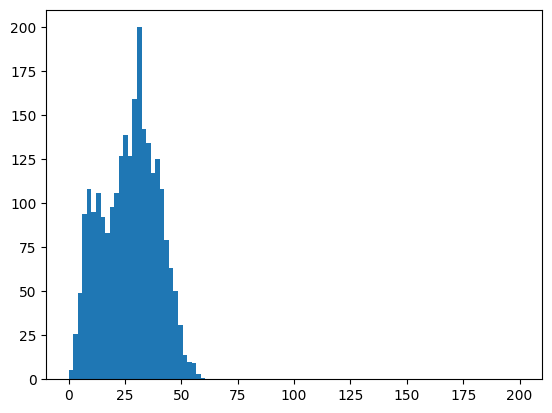

In [44]:
plt.hist(jnp.linalg.norm(sol_pos-(x0*scale), axis=1), bins=np.linspace(0.0, 200, 100))
plt.show()

In [45]:
jnp.linalg.norm(jnp.array([2, 2, 2]))

Array(3.46410162, dtype=float64)

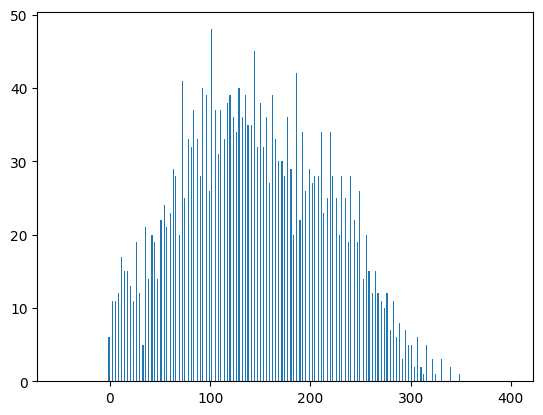

In [46]:
plt.hist(centered_track_time - init_times, bins=np.linspace(-50.0, 400, 400))
plt.show()

In [47]:
jnp.sqrt(3) * 2


Array(3.46410162, dtype=float64, weak_type=True)

In [50]:
print(jnp.rad2deg(track_src))

[115.76073569 106.1228205 ]
